In [6]:
!rm -rf data
!tar -xf data.tar

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np



In [2]:
class MyDataset(datasets.VisionDataset):
    def __init__(self, N, transform):
        self.transform = transform
        self.N = N

    def __getitem__(self, index):
        img1 = Image.open("data/clean/clean" + str(index+1) + ".png")
        img2 = Image.open("data/noisy/noisy" + str(index+1) + ".png")
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        return img1, img2
    
    def __len__(self):
        return self.N

transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
dataset = MyDataset(1000, transform)
train_set, validation_set = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=True)


In [3]:
class NoiseRemoval(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 8)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 8 * 8, 128)
        self.fc2 = nn.Linear(3524, 50 * 50)

    def forward(self, input):
        x = self.pool(F.relu(self.conv1(input)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(torch.cat((x.view(x.size(0), -1),
                          input.view(input.size(0), -1)), dim=1))
        x = torch.clamp(self.fc2(x), 0, 1)
        x = torch.reshape(x, (-1, 1, 50, 50))
        return x

model = NoiseRemoval()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


[128] loss: 0.073


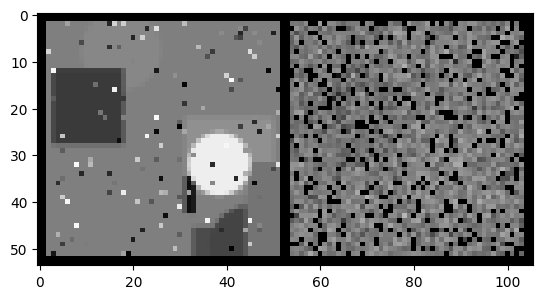

[129] loss: 0.072


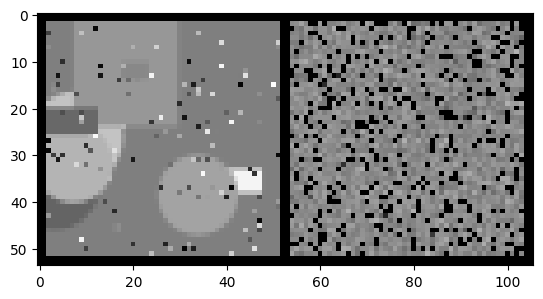

[130] loss: 0.072


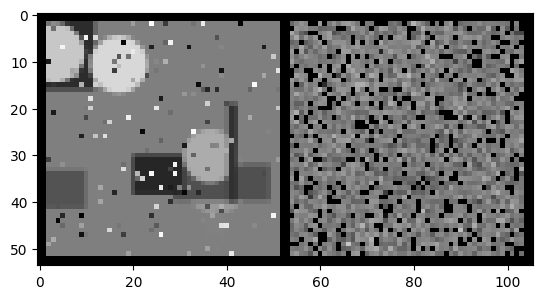

[131] loss: 0.072


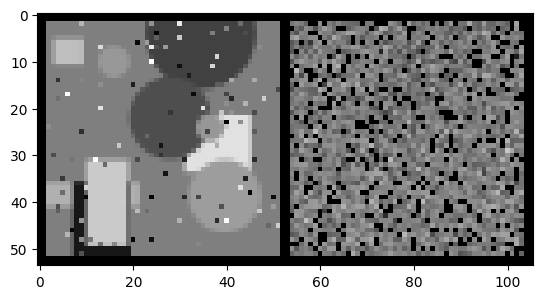

[132] loss: 0.072


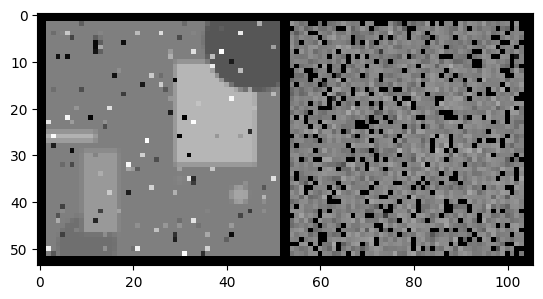

[133] loss: 0.072


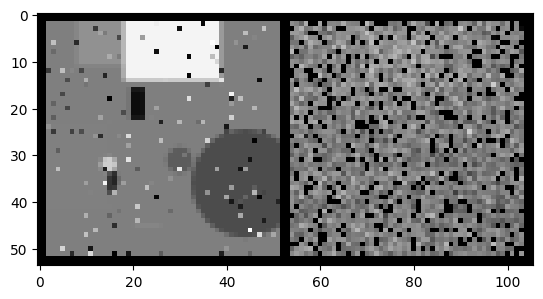

[134] loss: 0.072


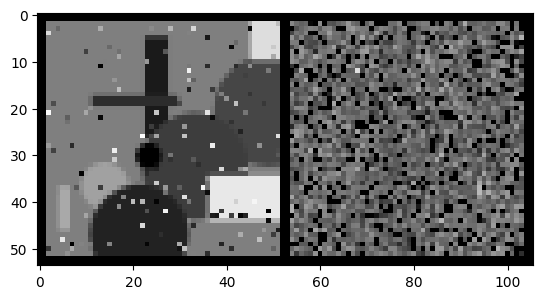

[135] loss: 0.072


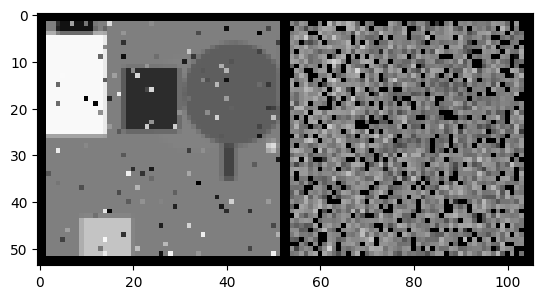

[136] loss: 0.072


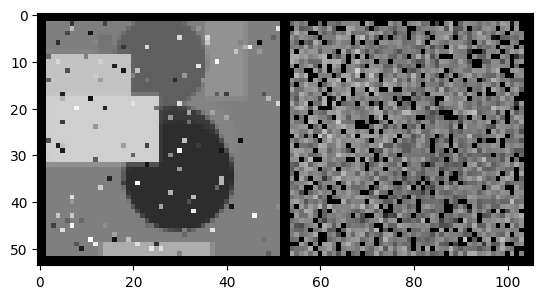

[137] loss: 0.072


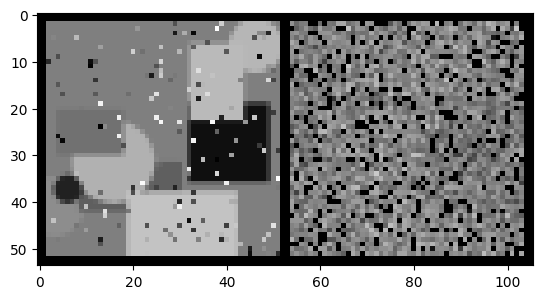

[138] loss: 0.072


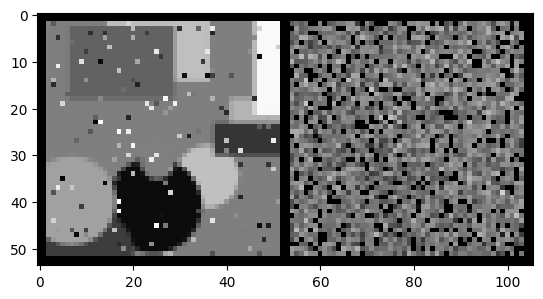

[139] loss: 0.071


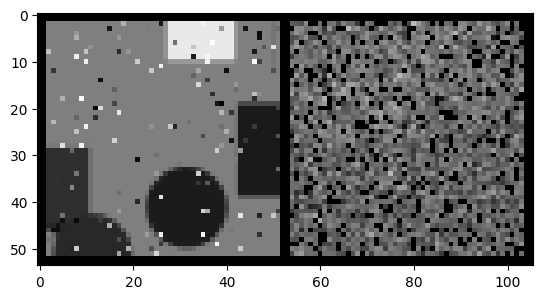

[140] loss: 0.071


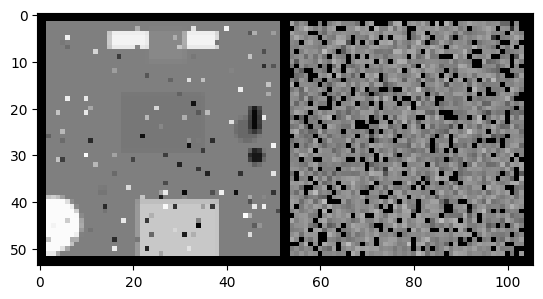

[141] loss: 0.071


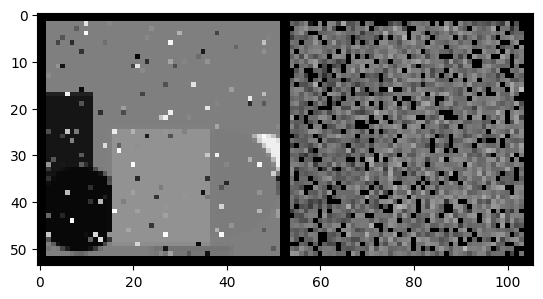

[142] loss: 0.071


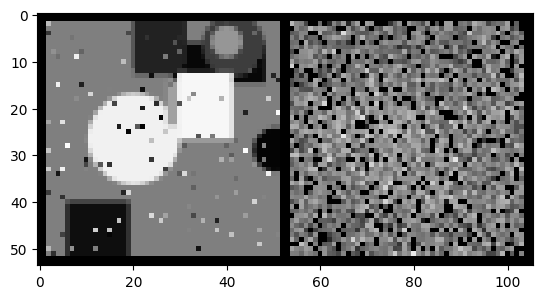

[143] loss: 0.071


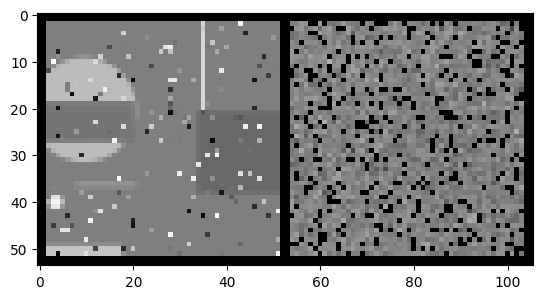

[144] loss: 0.071


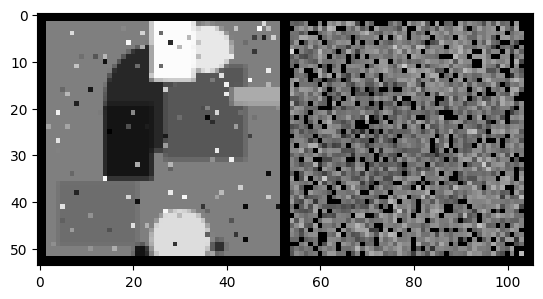

[145] loss: 0.070


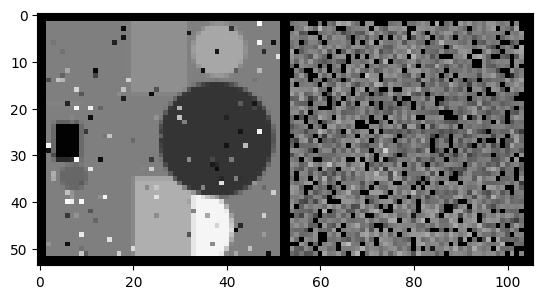

[146] loss: 0.071


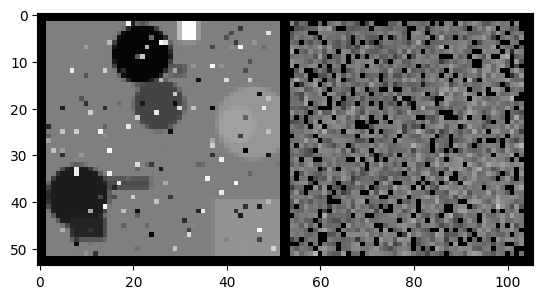

[147] loss: 0.071


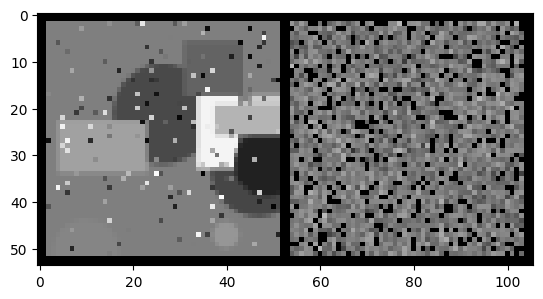

[148] loss: 0.070


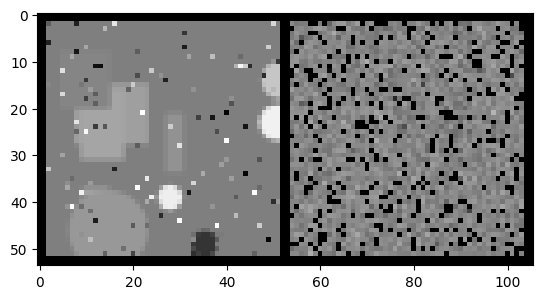

[149] loss: 0.070


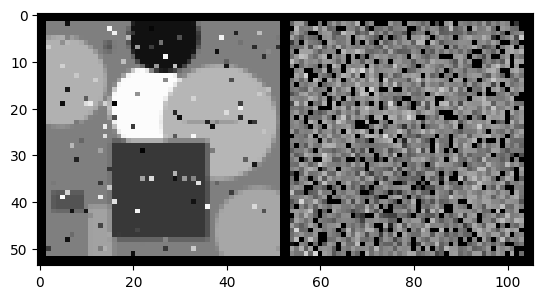

[150] loss: 0.070


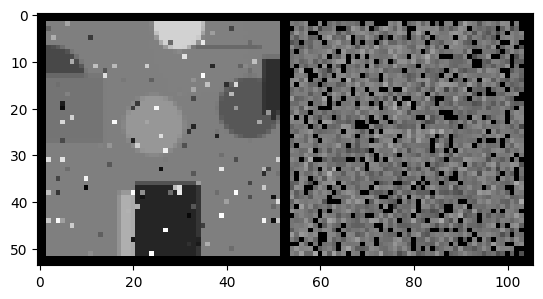

[151] loss: 0.070


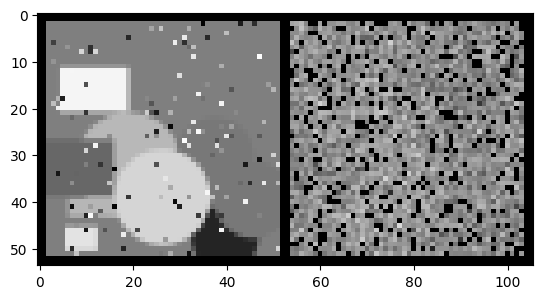

[152] loss: 0.070


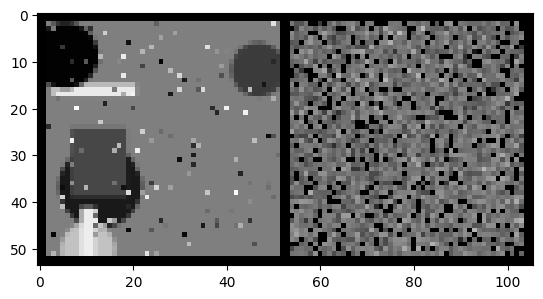

[153] loss: 0.070


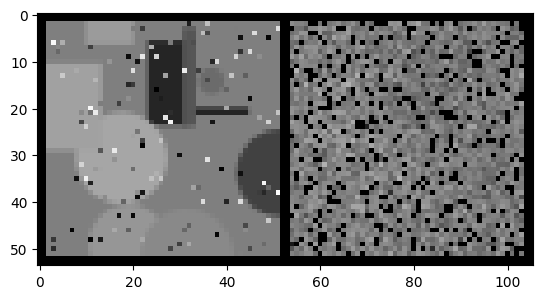

[154] loss: 0.070


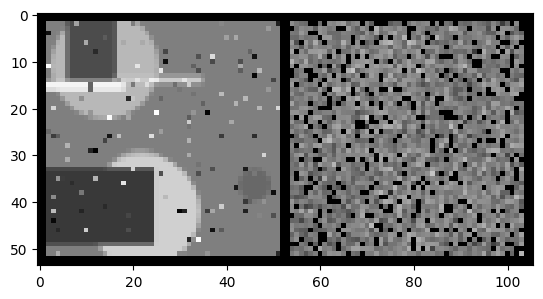

[155] loss: 0.069


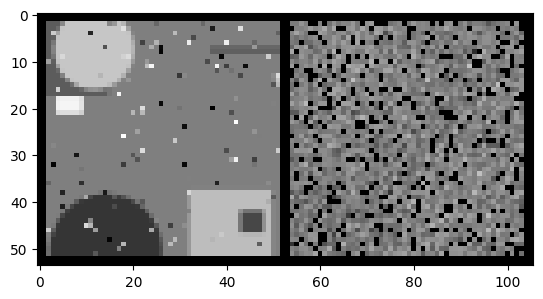

[156] loss: 0.069


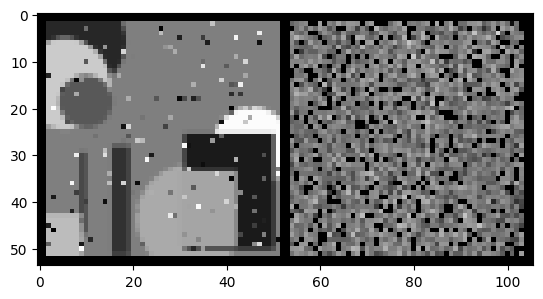

[157] loss: 0.069


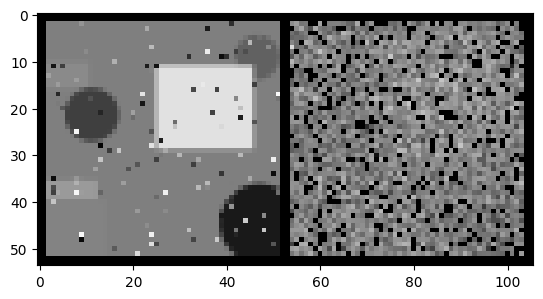

[158] loss: 0.069


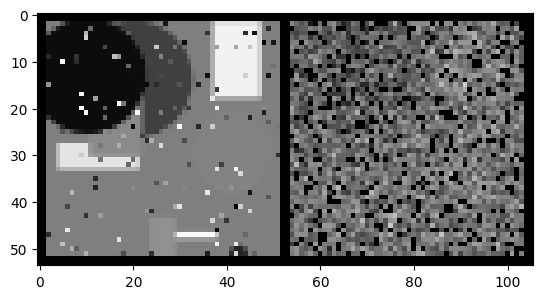

[159] loss: 0.069


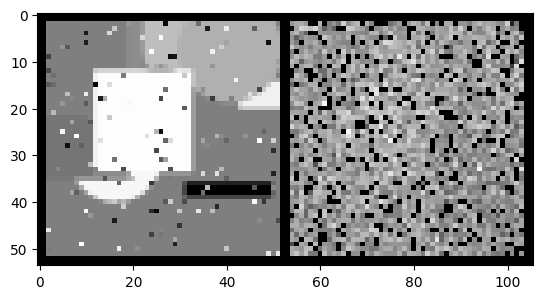

[160] loss: 0.069


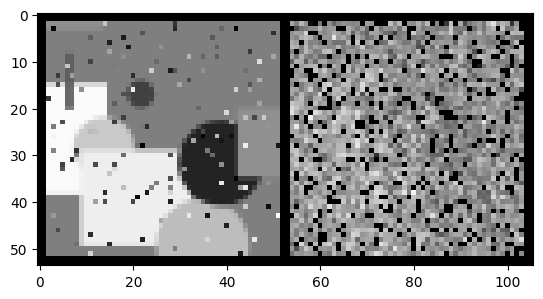

[161] loss: 0.069


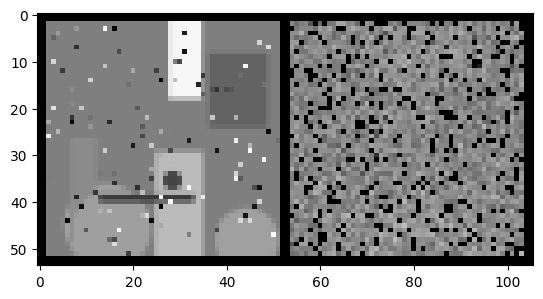

[162] loss: 0.069


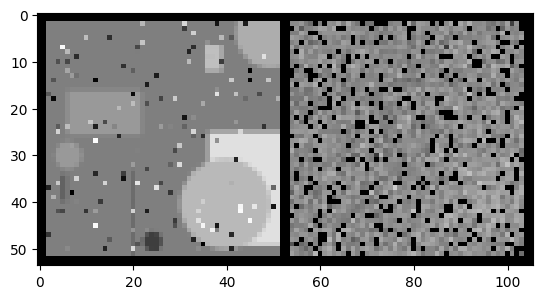

[163] loss: 0.069


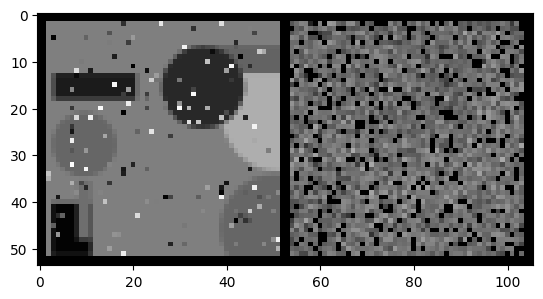

[164] loss: 0.069


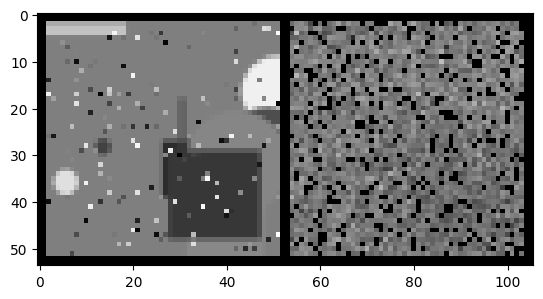

[165] loss: 0.069


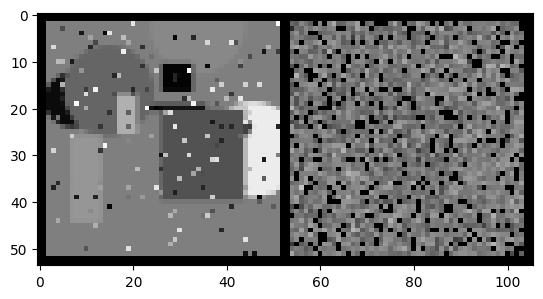

[166] loss: 0.068


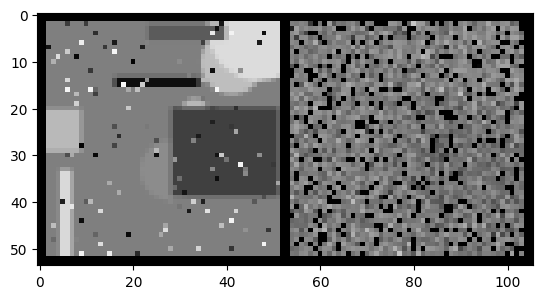

[167] loss: 0.068


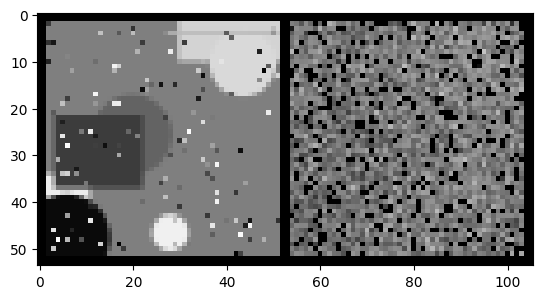

[168] loss: 0.068


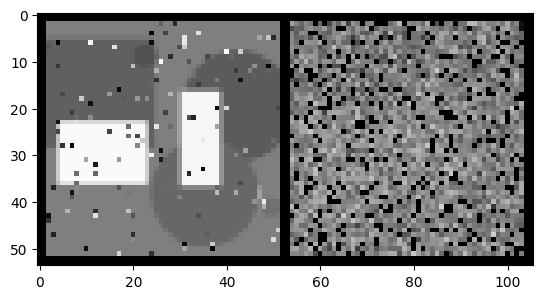

[169] loss: 0.068


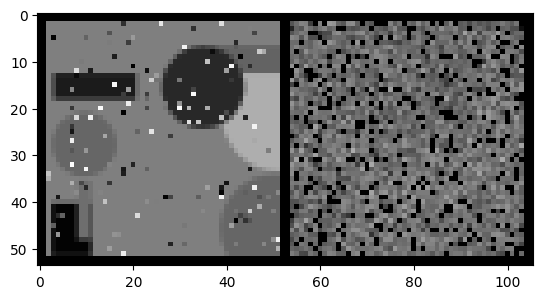

[170] loss: 0.068


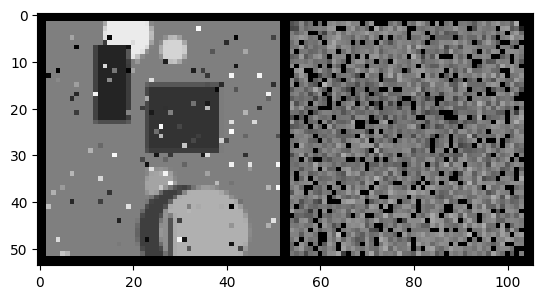

[171] loss: 0.068


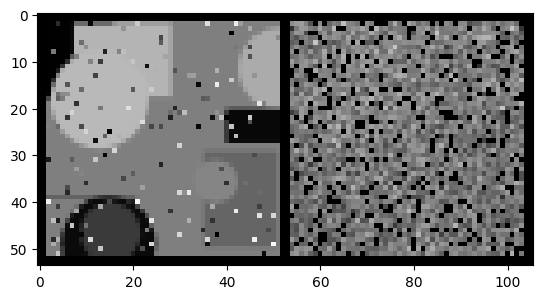

[172] loss: 0.068


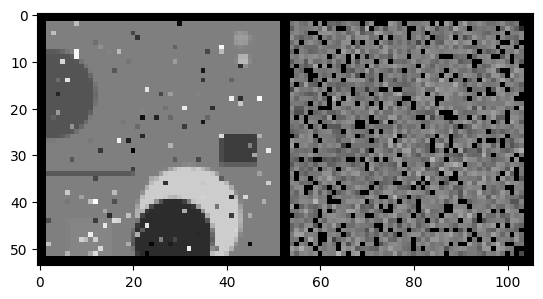

[173] loss: 0.068


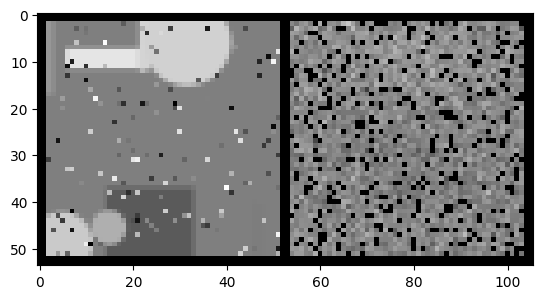

[174] loss: 0.068


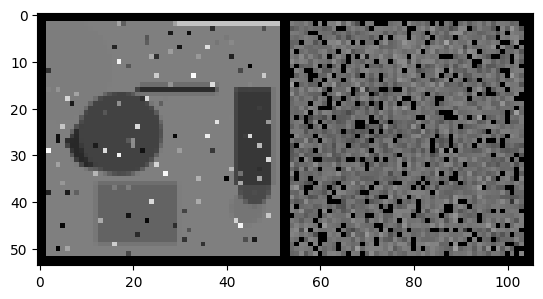

[175] loss: 0.068


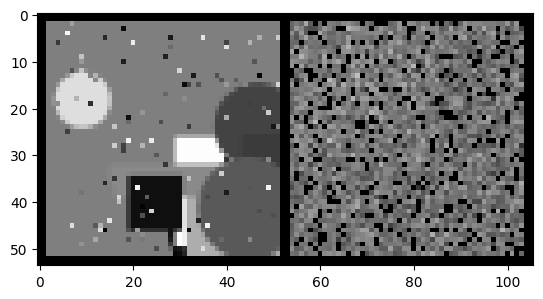

[176] loss: 0.068


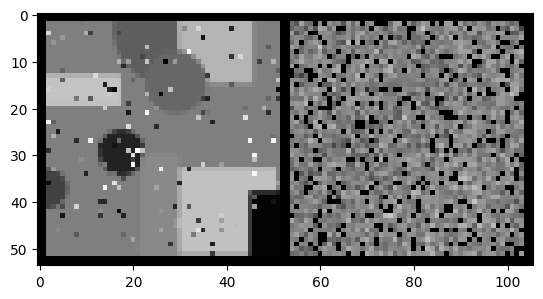

[177] loss: 0.068


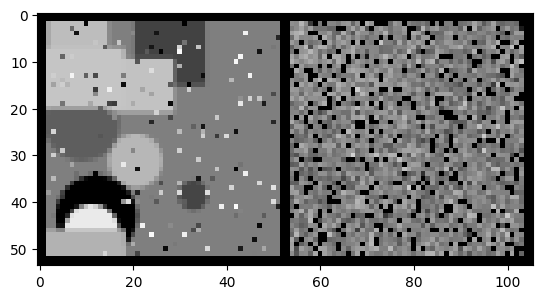

[178] loss: 0.067


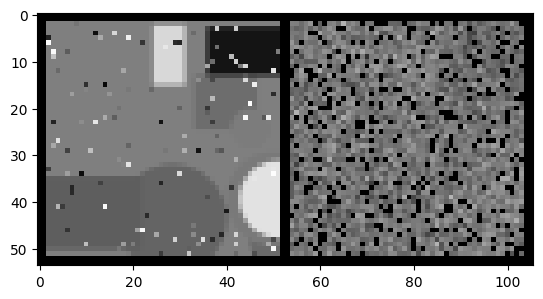

[179] loss: 0.067


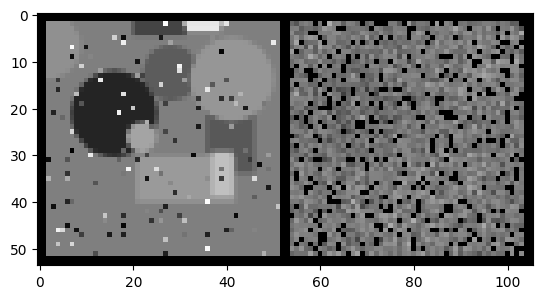

KeyboardInterrupt: 

In [4]:
for epoch in range(10000):
    running_loss = 0.0
    batches = 0
    sample_noisy, sample_denoised = None, None
    for i, data in enumerate(       train_loader, 0):
        clear, noisy = data
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clear)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batches += 1

        sample_noisy = noisy[-1]
        sample_denoised = output[-1]

    print(f'[{epoch + 1}] loss: {running_loss / batches:.3f}')
    # plt.imshow(transforms.ToPILImage()(sample_noisy), interpolation="bicubic")
    # plt.imshow(transforms.ToPILImage()(sample_denoised), interpolation="bicubic")
    grid = torchvision.utils.make_grid([sample_noisy, sample_denoised])
    plt.imshow(transforms.ToPILImage()(grid), interpolation="none")
    plt.show()